# Image processing for cell count and stain quantification
A common task in cell culture is staining and cell counting. For most laboratorist, the easiest way to record their observations is by snapping a picture of the sample with their phone and through the lens of the microscope. We can make this workflow even faster by using Python and Computer Vision to count the number of cells or measuring the amount of pixels of a certain color.

In [1]:
# !/Users/pauloc/Library/jupyterlab-desktop/envs/env_1/bin/python -m pip install matplotlib


## Importing packages

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load the image
image = cv2.imread('fotos/testground.jpg')

# Check if the image was loaded
if image is None:
    print("Error: Image not found or cannot be loaded.")
else:
    print("Image loaded successfully.")


Image loaded successfully.


In [4]:
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [5]:
# Apply binary thresholding
_, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)


In [6]:
# Find contours in the thresholded image
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Check if any contours were found
if not contours:
    print("No contours found in the image.")
    # Handle this case appropriately
else:
    # Assume the largest contour corresponds to the FOV
    largest_contour = max(contours, key=cv2.contourArea)


In [7]:
# Create a mask for the FOV
mask = np.zeros_like(gray)
cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

# Apply the mask to the original image
masked_image = cv2.bitwise_and(image, image, mask=mask)


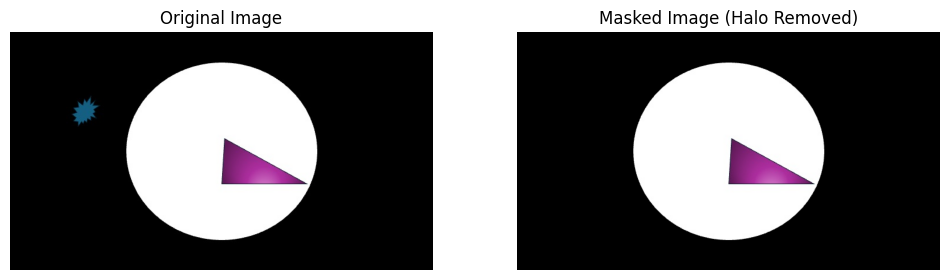

In [8]:
# Convert images to RGB for visualization
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)

# Display the original and masked images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_image_rgb)
plt.title('Masked Image (Halo Removed)')
plt.axis('off')
plt.show()


In [9]:
# Convert the masked image to HSV color space
hsv_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)


In [10]:
# Split HSV channels
h_channel, s_channel, v_channel = cv2.split(hsv_image)

# Define a saturation threshold to exclude low saturation pixels
saturation_threshold = 2  # Adjust as necessary

# Create a mask for pixels with sufficient saturation
saturation_mask = cv2.inRange(s_channel, saturation_threshold, 255)


In [11]:
# Mask the hue channel to exclude low saturation pixels
h_channel_masked = cv2.bitwise_and(h_channel, h_channel, mask=saturation_mask)


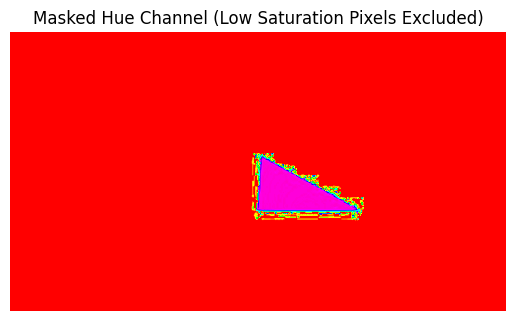

In [12]:
# Display the masked hue channel
plt.imshow(h_channel_masked, cmap='hsv')
plt.title('Masked Hue Channel (Low Saturation Pixels Excluded)')
plt.axis('off')
plt.show()


In [13]:
# Calculate the histogram of the masked hue channel
hist = cv2.calcHist([h_channel_masked], [0], saturation_mask, [180], [0, 180])

# Smooth the histogram to reduce noise
hist_smooth = cv2.GaussianBlur(hist, (9, 9), 0)

# Find the peak hue value (dominant hue)
dominant_hue = np.argmax(hist_smooth)
print(f"Dominant Hue: {dominant_hue}")


Dominant Hue: 153


In [14]:
# Set a delta around the dominant hue
delta_hue = 150  # Adjust as necessary

lower_hue = max(0, dominant_hue - delta_hue)
upper_hue = min(179, dominant_hue + delta_hue)
print(f"Hue Range: {lower_hue} - {upper_hue}")


Hue Range: 3 - 179


In [15]:
# Use the saturation and value ranges from the masked image
saturation_values = s_channel[mask == 255]
value_values = v_channel[mask == 255]

lower_saturation = max(saturation_threshold, np.percentile(saturation_values, 5))
upper_saturation = min(255, np.percentile(saturation_values, 99))

lower_value = max(0, np.percentile(value_values, 5))
upper_value = min(255, np.percentile(value_values, 99))

print(f"Saturation Range: {lower_saturation} - {upper_saturation}")
print(f"Value Range: {lower_value} - {upper_value}")


Saturation Range: 2 - 188.0
Value Range: 157.0 - 255


In [16]:
# Define the lower and upper bounds for the stain color
lower_stain = np.array([lower_hue, lower_saturation, lower_value])
upper_stain = np.array([upper_hue, upper_saturation, upper_value])


In [17]:
# Create the initial stain mask
stain_mask = cv2.inRange(hsv_image, lower_stain, upper_stain)

# Apply the FOV mask to the stain mask
stain_mask = cv2.bitwise_and(stain_mask, stain_mask, mask=mask)


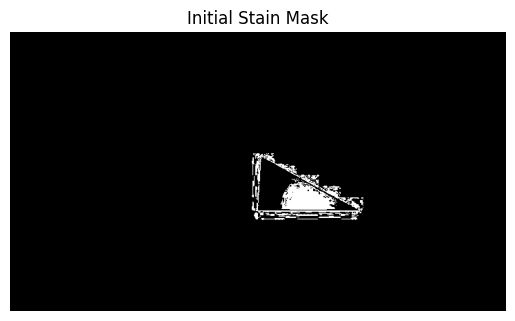

In [18]:
plt.imshow(stain_mask, cmap='gray')
plt.title('Initial Stain Mask')
plt.axis('off')
plt.show()


In [19]:
# Define a structuring element
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

# Remove small noise
cleaned_mask = cv2.morphologyEx(stain_mask, cv2.MORPH_OPEN, kernel)

# Fill small holes
cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)


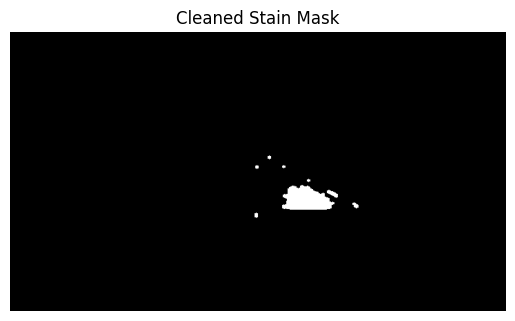

In [20]:
plt.imshow(cleaned_mask, cmap='gray')
plt.title('Cleaned Stain Mask')
plt.axis('off')
plt.show()


In [21]:
# Count the number of stained pixels
stained_pixels = cv2.countNonZero(cleaned_mask)

# Count the total number of pixels within the FOV
total_pixels = cv2.countNonZero(mask)

# Calculate the percentage of stained area
stain_percentage = (stained_pixels / total_pixels) * 100

print(f"Stained Pixels: {stained_pixels}")
print(f"Total Pixels in FOV: {total_pixels}")
print(f"Stain Coverage: {stain_percentage:.2f}%")


Stained Pixels: 2189
Total Pixels in FOV: 77367
Stain Coverage: 2.83%


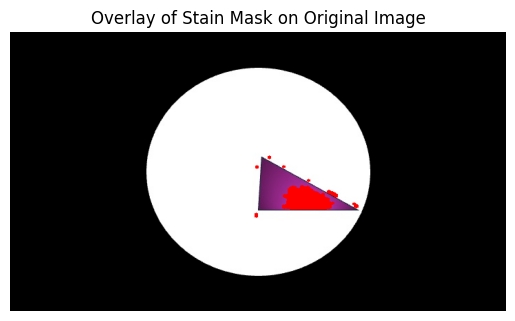

In [22]:
# Create a color overlay for the stained areas
overlay = masked_image.copy()
overlay[cleaned_mask == 255] = [0, 0, 255]  # Highlight stained areas in red

# Convert to RGB for display
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Display the overlay
plt.imshow(overlay_rgb)
plt.title('Overlay of Stain Mask on Original Image')
plt.axis('off')
plt.show()


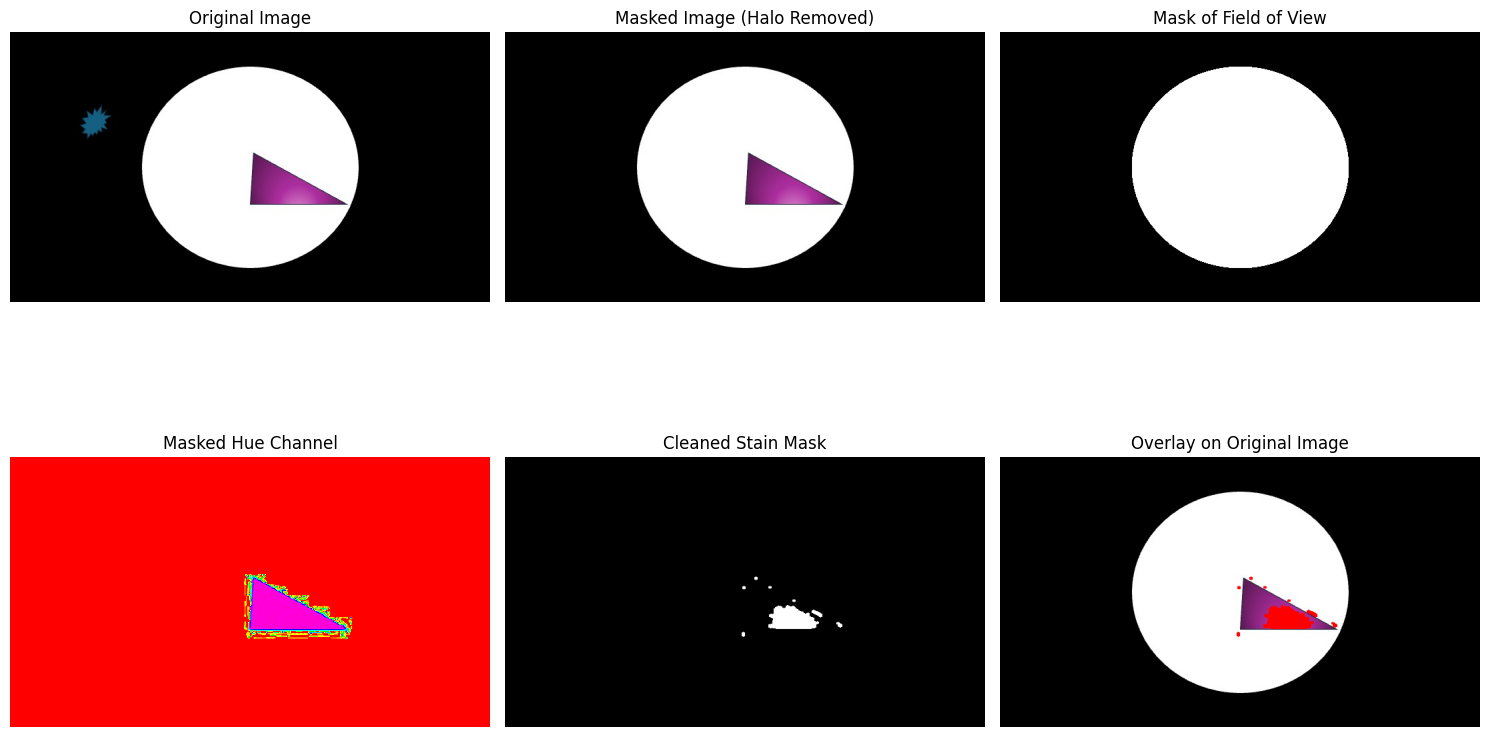

In [23]:
# Create a figure to display multiple images
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

# Masked Image
plt.subplot(2, 3, 2)
plt.imshow(masked_image_rgb)
plt.title('Masked Image (Halo Removed)')
plt.axis('off')

# Mask of FOV
plt.subplot(2, 3, 3)
plt.imshow(mask, cmap='gray')
plt.title('Mask of Field of View')
plt.axis('off')

# Masked Hue Channel
plt.subplot(2, 3, 4)
plt.imshow(h_channel_masked, cmap='hsv')
plt.title('Masked Hue Channel')
plt.axis('off')

# Cleaned Stain Mask
plt.subplot(2, 3, 5)
plt.imshow(cleaned_mask, cmap='gray')
plt.title('Cleaned Stain Mask')
plt.axis('off')

# Overlay of Stain Mask
plt.subplot(2, 3, 6)
plt.imshow(overlay_rgb)
plt.title('Overlay on Original Image')
plt.axis('off')

plt.tight_layout()
plt.show()
